**<div style="text-align: right"> Mathematical Methods for Bioengineers </div>**
**<div style="text-align: right"> Cristina Lopez Serrano </div>**
**<div style="text-align: right"> January 2019 </div>**

# <font color='maroon'>Coursework 3</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal
from scipy.signal import correlate,periodogram,welch
from mpl_toolkits import mplot3d
from scipy.signal import correlate
import math
from math import e
from sklearn import metrics
import sklearn
import statistics

In [2]:
#Download the file with the data. dFonF is a matrix that contains 7420 time points of fluorescence data from 75 neurons (74x7420)
#Fluorescence is an indicator of the neuronal activity, allowing us to visualize spikes of activity
#Download as well the matrix from CW1 that contains the data for frequency, spatial location and angle
mat2_contents = sio.loadmat('cw1_data2.mat')
dFonF = mat2_contents['dFonF']
mat1_contents = sio.loadmat('cw1_data1.mat')
mouse_theta = mat1_contents['mouse_theta']
mouse_x = mat1_contents['mouse_x']
mouse_y = mat1_contents['mouse_y']
fs = mat1_contents['fs'].flatten()[0]
L = np.size(dFonF[0, :])
t_im = np.linspace(0,L*1/fs,L)

## <font color='navy'>Exercise 1</font>
<font color='navy'>Load the full imaging dataset (see previous coursework) in the file cw1_data2.mat. You may have
noticed that the calcium fluorescence time series for each cell in this dataset comprises brief
“calcium transient” events interspersed amongst the baseline fluorescence. Write a function to
convert each time series into an event train, in which an (instantaneous) event corresponds to the
beginning of a detected calcium transient. For three selected cells, plot the continuous fluorescence
time series as a function of time, with the times of detected events marked by a tick overlaid on the
same plot.</font>

Three cells are chosen as example. The raw signal for each of them is plotted below.

In [3]:
#These variables contain the time series of the selected cells:
cell1=6; cell2=15; cell3=7;
signal1=dFonF[cell1, :];
signal2=dFonF[cell2, :];
signal3=dFonF[cell3, :];

I perform some filtering in order to detect the calcium spikes. The detection algorithm is adapted from the Pan-Tompkins algorithm, which is commonly used for peak detection in ECG signals. A derivative filter is first applied. The signal is then squared and a moving average is applied. Finally, the resulting signal is normalized and the threshold for peak detection is chosen as the root mean square value. <br>
Once the peaks are selected, the beginning of the calcium transients is marked to the left of the peak.

In [4]:
#Derivative filter, parameters from https://en.wikipedia.org/wiki/Pan%E2%80%93Tompkins_algorithm#Derivative_step
b =np.array([-0.2, -0.1, 0, 0.1, 0.2]);
der = np.empty([np.shape(dFonF)[0], np.shape(dFonF)[1]])
for i in range(len(dFonF)):
    der[i, :]=signal.filtfilt(b,1,dFonF[i, :])
#Squaring the signal
sq=np.square(der)
#Moving average calculation with a window of 200 samples, which ensures that a whole peak is considered
L = 200; # Window
c = (1/L)*np.ones(L);
ma = np.empty([np.shape(dFonF)[0], np.shape(dFonF)[1]])
for i in range(len(dFonF)):
    ma[i, :]=signal.filtfilt(c,1,sq[i, :]);
#Normalize the obtained signal dividing my the maximum value
nor=ma/np.amax(ma)

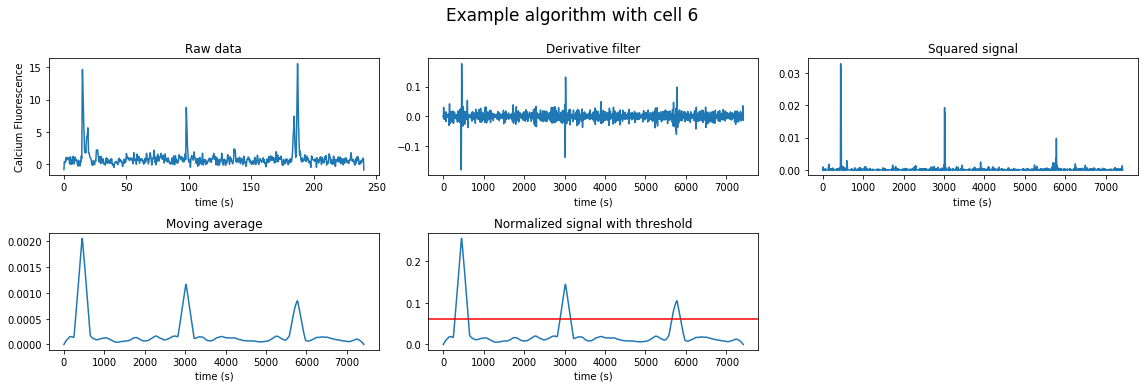

In [5]:
fig=plt.figure(figsize=(16,5));
fig.suptitle('Example algorithm with cell {}'.format(cell1), size=17, y=1.07)
ax1=plt.subplot(231);
plt.plot(t_im, dFonF[cell1, :]);
plt.title('Raw data');
plt.ylabel('Calcium Fluorescence');
plt.xlabel('time (s)');

ax2=plt.subplot(232);
plt.plot(der[cell1, :]);
plt.title('Derivative filter');
plt.xlabel('time (s)')

ax3=plt.subplot(233);
plt.plot(sq[cell1, :]);
plt.title('Squared signal');
plt.xlabel('time (s)')

ax4=plt.subplot(234);
plt.plot(ma[cell1, :]);
plt.title('Moving average');
plt.xlabel('time (s)')

ax5=plt.subplot(235);
plt.plot(nor[cell1, :]);
plt.title('Normalized signal with threshold');
plt.xlabel('time (s)')
plt.axhline(y=np.sqrt(np.mean(nor[cell1, :]**2))*1.3, color='r', linestyle='-')

plt.tight_layout()

The figure above shows the working process of the algorithm for an example cell. This algorithm allows single peak detection, avoiding problems when the peaks are double (peaks cannot be too close to each other due to the refractory period of the neurons).It also accounts for peaks of different scales

In [6]:
#Choose a threshold (above RMS value) that varies for each time series
thr=np.empty(len(dFonF))
for i in range(len(thr)):
    thr[i]=np.sqrt(np.mean(nor[i, :]**2))*1.3
sigthr = np.empty([np.shape(dFonF)[0], np.shape(dFonF)[1]])
#Select the values above the threshold
for i in range(len(nor)):
    for j in range(len(nor[i, :])):
        if nor[i, j]>thr[i]:
            sigthr[i, j]=1

In this part of the code, I am going to create five arrays to store the following information:
· Index where the peaks are found <br>
· y value (calcium fluorescence) of each peak <br>
· Index where calcium transients begin <br>
· y value of the beginning of the calcium transients <br>
· Event train of each neuron, consisting of an array of 1s indicating the beginning of calcium transient and 0s elsewhere

In [7]:
pk_idx=np.zeros((75, 10)); #Create array to store indexes of peaks
pk=np.zeros((75, 10)); #Create array to store values of peaks
beg_idx=np.zeros((75, 10));#Create array to store the indexes where a calcium transient begins
beg=np.zeros((75, 10));#Create array to store the value corresponding to the beginning of calcium transients
ev_train=np.zeros(np.shape(dFonF));#Create array to store event train (series of 0s and 1s)
for i in range(len(sigthr)):
    start=np.where(np.diff(sigthr[i, :])>0); #Find the indexes where a series of numbers above the threshold starts
    end=np.where(np.diff(sigthr[i, :])<0); #Find the indexes where a series of numbers above the threshold ends
    for j in range(len(start[0])):
        pk_idx[i][j]=np.argmax(dFonF[i, :][start[0][j]:end[0][j]])+start[0][j] #Find the index as the maximum value between 
        #start and end
        pk[i][j]=np.max(dFonF[i, :][start[0][j]:end[0][j]]) #Find the corresponding value of the peak
        beg_idx[i][j]=np.argmin(dFonF[i, :][start[0][j]:int(pk_idx[i][j])])+start[0][j] #Find the beginning to the left of the peak
        beg[i][j]=np.min(dFonF[i, :][start[0][j]:int(pk_idx[i][j])]) #Find the value of the beginning
        ev_train[i][int(beg_idx[i][j])]=1

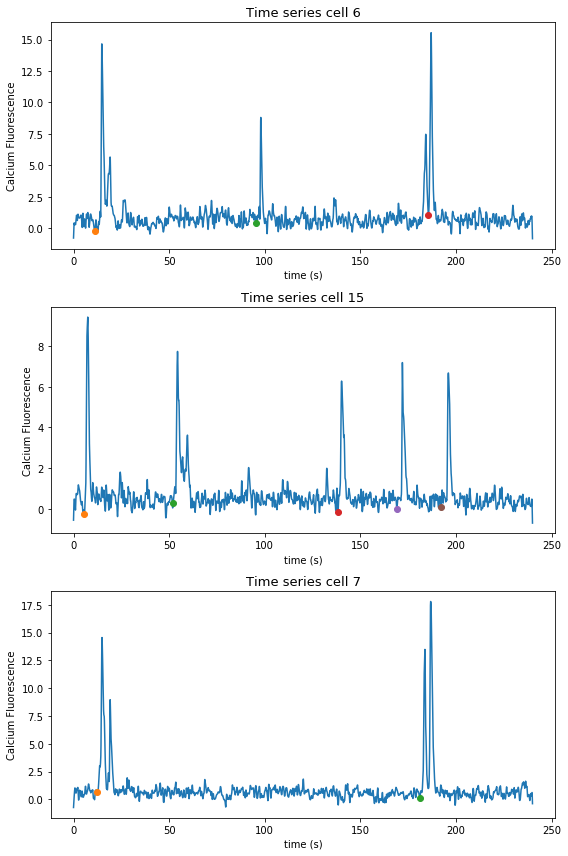

In [8]:
plt.figure(figsize=(8,12));
ax1=plt.subplot(311);
plt.plot(t_im, dFonF[cell1, :]);
beg1=np.zeros(1)
for i in range(10):
    if beg_idx[cell1, i]!=0:
        plt.plot(t_im[int(beg_idx[cell1, i])], beg[cell1, i], 'o')
        beg1=np.append(beg1, beg_idx[cell1, i])
beg1=np.delete(beg1, 0)
plt.title('Time series cell {0:.0f}'.format(cell1), fontsize=13);
plt.ylabel('Calcium Fluorescence');
plt.xlabel('time (s)');
#plt.setp(ax1.get_xticklabels(), visible=False);

beg2=np.zeros(1)
ax2=plt.subplot(312);
plt.plot(t_im, dFonF[cell2, :]);
for i in range(10):
    if beg_idx[cell2, i]!=0:
        plt.plot(t_im[int(beg_idx[cell2, i])], beg[cell2, i], 'o')
        beg2=np.append(beg2, beg_idx[cell2, i])
beg2=np.delete(beg2, 0)
plt.title('Time series cell {0:.0f}'.format(cell2), fontsize=13);
plt.ylabel('Calcium Fluorescence');
plt.xlabel('time (s)');
#plt.setp(ax2.get_xticklabels(), visible=False);

beg3=np.zeros(1)
ax3=plt.subplot(313);
plt.plot(t_im, dFonF[cell3, :]);
for i in range(10):
    if beg_idx[cell3, i]!=0:
        plt.plot(t_im[int(beg_idx[cell3, i])], beg[cell3, i], 'o')
        beg3=np.append(beg3, beg_idx[cell3, i])
beg3=np.delete(beg3, 0)
plt.title('Time series cell {0:.0f}'.format(cell3), fontsize=13);
plt.xlabel('time (s)');
plt.ylabel('Calcium Fluorescence');
plt.tight_layout()

## <font color='navy'>Exercise 2</font>
<font color='navy'>As described in previous coursework exercises (particularly Coursework One), the data is
collected from a mouse running in repeated loops around a circular track. Write a function which
returns the data for a cell in the form response[trial,position], where trial indicates which loop
around the track the mouse is on, position indicates the binned spatial angle of the mouse’s
location, and response is 0 or 1 as above. Plot this as a `rastergram’ (ticks indicating events on axes
showing trials (y axis) vs angular location (x axis)) for three example cells showing high, medium and
low selectivity of the firing of the cell to the mouse’s location on the circular track.</font>

The first step is to divide the angles in bins and correlate each angular position to its corresponding bin.

In [9]:
#First I am going to define the bins and their respective values
bins=np.linspace(0, 360, 20) #This function returns the limits of the bins
#Now I am going to find the value of each bin as the average between its limits
bin_val=np.zeros(len(bins)-1)
for i in range(len(bins)-1):
    bin_val[i]=(bins[i]+bins[i+1])/2
pos_bin_all=np.zeros(len(ev_train[0, :])) #This vector will store the binned angles corresponding to the position at each recording
idx=np.digitize(mouse_theta, bins) #This function returns the value of the index of the corresponding bin.
#For example, for an angle that falls in bin 2 it will return value "2"
#Now we have to relate those indexes to the value of the bin. For example, bin "2" corresponds to an angle of "3.6"
for i in range(len(pos_bin_all)):
    pos_bin_all[i]=bin_val[idx[i]-1]

Now I am going to obtain the "trials", indicating which loop around the track the mouse is on for each sample.

In [10]:
loops=np.zeros(len(mouse_theta)) #Empty vector in which each position will correspond to the number of loop the mouse is on
loopnum=1 #Auxiliary variable indicating number of loop
loopch=np.zeros(1) #auxiliary array containing the indices in which there is a change in loop (mouse crosses "finish line")
for i in range(len(mouse_theta)-1):
    loops[i]=loopnum; #Iteratively add to the empty vector the loop number
    if mouse_theta[i]<mouse_theta[0] and mouse_theta[i+1]>mouse_theta[0] and (i-loopch[loopnum-1])>150: #Condition for loop change
        #Conditions: angle goes back to initial one AND there are more than 150 positions in between loop changes --> This is
        #to account for situations in which the mouse moves back and forth
        loopnum=loopnum+1;
        loopch=np.append(loopch, i)
loops[len(mouse_theta)-1]=loops[len(mouse_theta)-2] #Correct last position of the array

Now, for three selected cells, I'm going to plot the rastrergram indicating trials on the y axis vs angular location on the x axis.

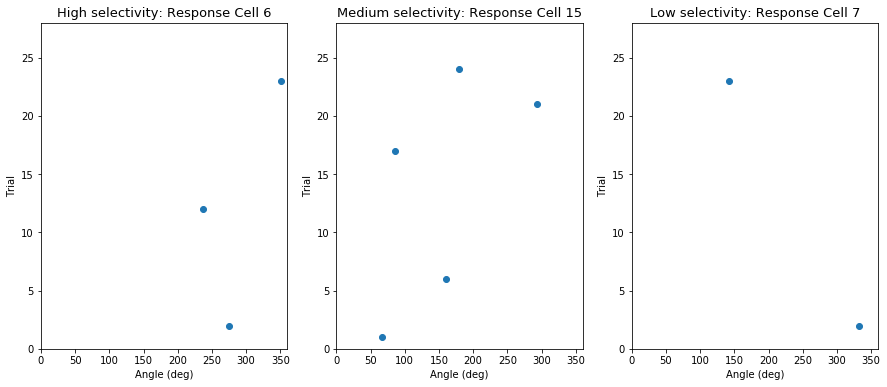

In [11]:
plt.figure(figsize=(15, 6))
#Cell 1
pos1=np.empty(len(beg1));
trial1=np.empty(len(beg1));
ax1=plt.subplot(131);
for i in range (len(beg1)): #beg1 is the vector that stores the indices corresponding to the begining of an event
    pos1[i]=pos_bin_all[int(beg1[i])]
    trial1[i]=loops[int(beg1[i])]
plt.scatter(pos1, trial1)
plt.axis([0, 360, 0, 28]);
plt.title('High selectivity: Response Cell {0:.0f}'.format(cell1), fontsize=13);
plt.ylabel('Trial');
plt.xlabel('Angle (deg)');

#Cell 2
pos2=np.empty(len(beg2));
trial2=np.empty(len(beg2));
ax2=plt.subplot(132);
for i in range (len(beg2)): #beg2 is the vector that stores the indices corresponding to the begining of an event
    pos2[i]=pos_bin_all[int(beg2[i])]
    trial2[i]=loops[int(beg2[i])]
plt.scatter(pos2, trial2)
plt.axis([0, 360, 0, 28]);
plt.title('Medium selectivity: Response Cell {0:.0f}'.format(cell2), fontsize=13);
plt.ylabel('Trial');
plt.xlabel('Angle (deg)');

#Cell 3
pos3=np.empty(len(beg3));
ax3=plt.subplot(133);
trial3=np.empty(len(beg3));
for i in range (len(beg3)): #beg1 is the vector that stores the indices corresponding to the begining of an event
    pos3[i]=pos_bin_all[int(beg3[i])]
    trial3[i]=loops[int(beg3[i])]
plt.scatter(pos3, trial3)
plt.axis([0, 360, 0, 28]);
plt.title('Low selectivity: Response Cell {0:.0f}'.format(cell3), fontsize=13);
plt.ylabel('Trial');
plt.xlabel('Angle (deg)');

Cells with high selectivity fire at similar angles in different trials. Cells with low selectivity show large variation in the angles at which they fire.

However, this method poses a problem: neurons that fire close to 360º and close to 0º will be interpreted as being really far, when actually they will be quite specific. An option to deal with this situation is to calculate specificity considering spatial location (x, y) instead of the angle.

In [12]:
def spec_xy(n):
    aux=np.zeros(1);
    for i in range(10):
        if beg_idx[n, i]!=0:
            aux=np.append(aux, beg_idx[n, i])
    aux=np.delete(aux, 0)
    dist=np.zeros(1);
    for i in range(len(aux)):
        for j in range(len(aux)):
            if (i!=j):
                a=((mouse_x[int(aux[i])]-mouse_x[int(aux[j])])**2)+((mouse_y[int(aux[i])]-mouse_y[int(aux[j])])**2)
                dist=np.append(dist, a)
    dist=np.delete(dist, 0)
    avgdist=np.mean(dist)
    return avgdist

In [13]:
msdist=np.empty(75)
for i in range(75):
    msdist[i]=spec_xy(i)

C:\Users\Cristina\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Cristina\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
print("The mean square distance between the points of cell %d (high selectivity) is %.1f." % (cell1, msdist[6]))

The mean square distance between the points of cell 6 (high selectivity) is 27090.3.


In [15]:
print("The mean square distance between the points of cell %d (medium selectivity) is %.1f." % (cell2, msdist[15]))

The mean square distance between the points of cell 15 (medium selectivity) is 41582.2.


In [16]:
print("The mean square distance between the points of cell %d (low selectivity) is %.1f." % (cell3, msdist[7]))

The mean square distance between the points of cell 7 (low selectivity) is 69849.4.


We can observe that, as expected, the distances are higher for cells with low selectivity

## <font color='navy'>Exercise 3</font>
<font color='navy'>For these 3 cells, calculate the mutual information between the binary response variable and
spatial angle, theta. Use 20 bins for spatial angle. Does this correspond to what you expect based on
the previous plots?</font>

In [17]:
def entropy(px):
    index = px>0
    H = -np.sum( px[index] * np.log2(px[index]) )
    return H
N=20;

In [18]:
I=np.empty(75) #array to store the mutual information
H_pos=np.empty(75) #array to store spatial position entropy
for i in range(75):
    c_ev,bins = np.histogram(ev_train[i, :],N) 
    c_pos,bins = np.histogram(mouse_theta[:, 0],N) 
    c_evpos,bins_ev,bins_pos = np.histogram2d(ev_train[i, :],mouse_theta[:, 0],N) 
    P_ev = c_ev / c_ev.sum() #Probability distribution of event train
    P_pos = c_pos / c_pos.sum() #Probability distribution of spatial angle
    P_evpos = c_evpos / c_evpos.sum() #Joint probability distribution
    H_ev = entropy(P_ev) #Entropy of calcium transients
    H_pos[i] = entropy(P_pos) #Entropy of spatial location
    H_evpos = entropy(P_evpos) #Joint entropy
    I[i] = H_ev + H_pos[i] - H_evpos

In [19]:
print("The mutual information of cell %d (high selectivity) is %.5f." % (cell1, I[cell1]))

The mutual information of cell 6 (high selectivity) is 0.00120.


In [20]:
print("The mutual information of cell %d (medium selectivity) is %.5f." % (cell2, I[cell2]))

The mutual information of cell 15 (medium selectivity) is 0.00113.


In [21]:
print("The mutual information of cell %d (low selectivity) is %.5f." % (cell3, I[cell3]))

The mutual information of cell 7 (low selectivity) is 0.00089.


We can see that the mutual information is higher for the high selectivity cell. This was expected, since this cell should provide more information about angular position than the one with low selectivity. This method would allow us to still classifiy cells at highly selective that fire close to 0º-360º.

## <font color='navy'>Exercise 4</font>
<font color='navy'>How much information does the “best” cell convey about spatial location, compared to the
uncertainty (entropy) of the spatial location variable?</font>

In [22]:
best=np.argmax(I)
print("The mutual information of cell with high specificity is %.4f" % (I[best]))
print("The uncertainty of the spatial location variable is %.4f" % (H_pos[best]))

The mutual information of cell with high specificity is 0.0019
The uncertainty of the spatial location variable is 4.1312


The ratio between this two values is very low. This means that, even in the "best" cell the amount of information is very low with respect to the uncertainty. In general, this means that from the information we have in the calcium transients we cannot infer the spatial position of the mouse in the track. 

## <font color='navy'>Exercise 5</font>
<font color='navy'>Plot the distribution of spatial information values (in bits) for all cells, and briefly discuss your
results.</font>

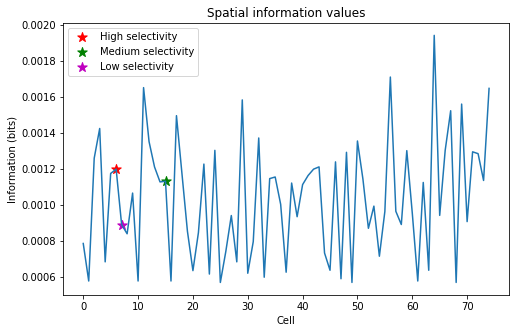

In [23]:
plt.figure(figsize=(8,5));
plt.plot(I);
plt.title('Spatial information values');
plt.xlabel('Cell');
plt.ylabel('Information (bits)');
plt.scatter(cell1, I[cell1], c='r', marker="*", s=100, label='High selectivity');
plt.scatter(cell2, I[cell2], c='g', marker="*", s=100, label='Medium selectivity');
plt.scatter(cell3, I[cell3], c='m', marker="*", s=100, label='Low selectivity');
plt.legend();

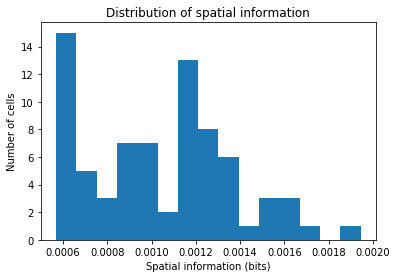

In [24]:
counts1, bins1, bars1 = plt.hist([I], bins=15)
plt.title('Distribution of spatial information')
plt.xlabel("Spatial information (bits)")
plt.ylabel("Number of cells")
plt.show()

The mouse runs 28 times around the circular track so for a neuron to provide significant information correlated with the angular position it should have close to 28 spikes. However, looking at the event trains for each neuron, the ones with more events don't have more than 5 or 6 spikes, while some only have 1. <br>
Spatial information is quite low for all the cells (ranges from 0.0006 bits to 0.002 bits). This means that the data from calcium transients doesn't provide a reliable information about the spatial position of the mouse around the track. This might be because the population of neurons that is monitored is not larged enough, maybe the movement is coordinated by a more complex group of neurons. 